In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pyswarms as ps
import pandas as pd
import scipy
from scipy.stats import norm, gamma

In [124]:
def gamma_normal_pdf(x, lam, alpha, beta, mu, sigma):
    """Probability density of Gamma-Normal mixture distribution.

    Parameters
    ----------
    x : vector or scalar
        Realization of random variable :code:'(N_obs, )'
        
    lam : vector or scalar
        Proportion of Gamma distribution.

    alpha : vector or scalar
        Location parameter of Gamma.

    beta : vector or scalar
        Scale parameter of Gamma.

    mu : vector or scalar
        Mean parameter of Normal.

    sigma : vector or scalar
        Variance parameter of Normal.

    Returns
    ----------
    numpy.ndarray
        computed density of size :code:`(N_obs, )`
    """
    
    g = gamma.pdf(x, a=alpha, scale=1 / beta)
    n = norm.pdf(x, loc=mu, scale=sigma)
    
    return lam * g + (1-lam) * n

def log_lik_gamma_normal(b, x):
    """
    Parameters
    ----------
    b : numpy.ndarray
        sets of inputs shape :code:'(n_particles, 5)'

    x : numpy.ndarray
        the gene expression vector of inputs shape :code:'(N_obs, )'

    Returns
    ----------
    numpy.ndarray
        computed log likelihood of Gamma-Normal mixture of size :code:`(n_particles, )`
    """
    
    lams = b[:, 0]; alphas = b[:, 1]; betas = b[:, 2]; mus = b[:, 3]; sigmas = b[:, 4]
    n_particles = lams.shape[0]
    log_lik = np.zeros(n_particles)
    
    for i in range(n_particles):
        pdf = gamma_normal_pdf(x, lams[i], alphas[i], betas[i], mus[i], sigmas[i])
        log_lik[i] = np.log(pdf + 1e-100).sum()
        
    return -log_lik

In [191]:
np.random.seed(12)
b = np.random.random((10, 5))
n = norm.rvs(size=100, loc=3, scale=1)
g = gamma.rvs(size=100, a=1, scale=1)
x = np.hstack((n, g))

log_lik_gamma_normal(b, x=x)

array([932.34226257, 654.58957402, 947.75843027, 477.10897039,
       834.72938324, 519.2580177 , 430.90185813, 405.00534838,
       435.8438143 , 674.49169466])

In [192]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
n = 50
# Call instance of PSO
bounds = [(0, 0, 0, -np.inf, 0), (1, np.inf, np.inf, np.inf, np.inf)]
optimizer = ps.single.GlobalBestPSO(n_particles=n, dimensions=5, options=options, bounds=bounds, init_pos=0.5*np.ones((n, 5)))
# Perform optimization
best_cost, best_pos = optimizer.optimize(log_lik_gamma_normal, iters=100, x=x)

2021-02-28 11:54:45,823 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/100, best_cost=319/Users/elviscui/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
pyswarms.single.global_best:   0%|          |0/100, best_cost=319/Users/elviscui/opt/anaconda3/lib/python3.8/site-packages/pyswarms/backend/operators.py:198: RuntimeWarning: invalid value encountered in add
  temp_position += swarm.velocity
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=318
2021-02-28 11:54:46,733 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 318.2121831217237, best pos: [0.53003003 0.97719238 0.81666204 2.76685011 1.09700104]


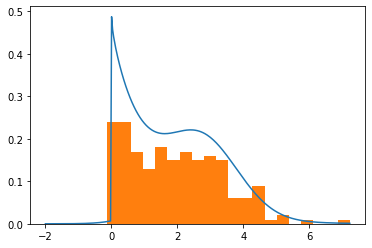

In [193]:
points = np.linspace(-2, np.max(x), 300)
densities = gamma_normal_pdf(points, best_pos[0], best_pos[1], best_pos[2], best_pos[3], best_pos[4])
plt.plot(points, densities)
plt.hist(x, weights=2*np.ones(len(x)) / len(x), bins=20)
plt.show()

In [221]:
np.array([best_pos[0], best_pos[3], best_pos[4]])

array([0.52941714, 2.76676059, 1.09692591])

In [216]:
np.hstack([rest[:, 0].reshape((-1, 1)), xxyy, rest[:, 1:]]).shape

(900, 4)

2021-02-28 12:31:07,966 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/100, best_cost=348<ipython-input-124-66700eeb2db6>:57: RuntimeWarning: invalid value encountered in log
  log_lik[i] = np.log(pdf + 1e-100).sum()
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=318
2021-02-28 12:31:09,690 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 318.2120769765089, best pos: [0.52876189 0.97721801 0.81777488 2.76576782 1.09735066]


(0.01, 7.0)

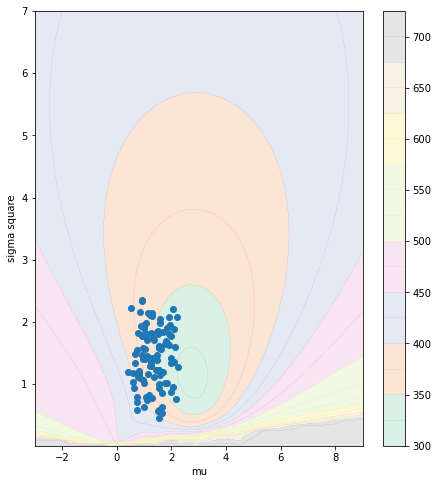

In [226]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=5, options=options)
best_cost, best_pos = optimizer.optimize(log_lik_gamma_normal, iters=100, x=x)
m = 60; n = 90
xx, yy = np.meshgrid(np.linspace(-3, 9, m), np.linspace(0.01, 7, n))
rest = np.repeat(best_pos[:3].reshape((-1, 1)), m * n, 1).T
xxyy = np.array((xx, yy)).reshape(2, -1).T
xxyy_rest = np.hstack([rest, xxyy])
points = np.array(optimizer.pos_history)

plt.figure(figsize=(25, 8))

z_ = log_lik_gamma_normal(xxyy_rest, x=x).reshape((n, m))

# PLOT normal loss fct
plt.subplot(131)
plt.contourf(xx, yy, z_, 15, cmap='Pastel2', alpha=0.5)
plt.colorbar()
plt.scatter(points[2, :, 3], points[2, :, 4])
plt.xlabel("mu")
plt.ylabel("sigma square")
plt.xlim(-3, 9)
plt.ylim(0.01, 7)

In [118]:
X = pd.read_csv("datasets/cm_Cortex1_Smart-seq2.csv").iloc[:, 1:]

In [145]:
data = np.log(np.array(X) + 1.01)
theta = np.random.random((10, 5))
log_lik_gamma_normal(b, data[:, 0])

array([ 61519.74130941,  80211.66537578,  13829.84650676,  -3606.73899127,
         4430.56684569, -20757.73992303, -24989.08700992,  -6937.24632082,
        62231.99776295,   -484.01480075])

In [160]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
n = 100
bounds = [(0, 0, 0, -np.inf, 0), (1, 10, 10, 10, 10)]
# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=n, dimensions=5, options=options, bounds=bounds, init_pos=0.5*np.ones((n, 5)))
# Perform optimization
best_cost, best_pos = optimizer.optimize(log_lik_gamma_normal, iters=100, x=data[:, 0])

2021-02-27 21:23:52,420 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-5.21e+4
2021-02-27 21:24:17,936 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -52136.71213540182, best pos: [0.89144711 0.41524623 9.9888267  3.17739141 2.08624875]


In [161]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
n = 100
bounds = [(0, 0, 0, -np.inf, 0), (1, 10, 10, 10, 10)]
# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=n, dimensions=5, options=options, bounds=bounds, init_pos=0.5*np.ones((n, 5)))
# Perform optimization
best_cost, best_pos = optimizer.optimize(log_lik_gamma_normal, iters=100, x=data[:, 0])

2021-02-27 21:24:26,008 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-5.16e+4
2021-02-27 21:24:51,574 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -51561.018358849265, best pos: [0.86608454 0.39596872 9.63220005 3.75794639 2.31554597]


In [162]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
n = 100
bounds = [(0, 0, 0, -np.inf, 0), (1, 10, 10, 10, 10)]
# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=n, dimensions=5, options=options, bounds=bounds, init_pos=0.5*np.ones((n, 5)))
# Perform optimization
best_cost, best_pos = optimizer.optimize(log_lik_gamma_normal, iters=100, x=data[:, 0])

2021-02-27 21:24:51,580 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-5.2e+4
2021-02-27 21:25:17,132 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -51967.324163946716, best pos: [0.8852479  0.46605638 9.98008848 2.361166   2.31091797]


In [163]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
n = 100
bounds = [(0, 0, 0, -np.inf, 0), (1, 10, 10, 10, 10)]
# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=n, dimensions=5, options=options, bounds=bounds, init_pos=0.5*np.ones((n, 5)))
# Perform optimization
best_cost, best_pos = optimizer.optimize(log_lik_gamma_normal, iters=100, x=data[:, 0])

2021-02-27 21:25:17,139 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-5.18e+4
2021-02-27 21:25:42,933 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -51784.44179674306, best pos: [0.87158042 0.3836844  9.86876596 3.42840221 2.20736308]
